# Graduate Statement Analysis

## Overview

In this analysis, we attempt to identify the characteristics of a "good" statement of purpose by analyzing graduate application statements.

#### Motivation
There seems to be little consensus on what the best practices are for a statement of purpose. Beyond a universal agreement that proper grammar is important, there is almost no advice available that doesn't have an antithetical counterpart. 

Rather than relying on bits and pieces from a few write-ups on the subject, we will attempt to aggregate thousands of different opinions and draw conclusions from a comprehensive analysis.  

#### Process Outline
0. Scrape data
1. Pre-process data
2. Assess statement quality 
    * Reading level?
    * ~~Sentiment analysis on replies~~ (see note in [Sentiment Analysis](#Sentiment-Analysis-(Critiques)) section)
3. Topic modeling on critiques
    * LDA
        * Topic coherence
    * NMF
    * LSA
4. Doc2Vec/FastText embeddings to find (dis)similar critiques + SoPs
    * Visualize embeddings ~ t-sne/umap
    * Cluster embeddings ~ k-means

#### Notes and Ideas
* Option 1: attempt to generate critiques given SoP as input. Build a language model based on WikiText103. Retrain final layers
    * Pro - Fairly straight forward application of text generation with seq2seq
        * [Text Generation](https://paperswithcode.com/area/natural-language-processing/text-generation)
    * Con - Results will likely be sub par and not fully address the original intent of the analysis
* Option 2: Identify key words/phrases that describe that summarize the critiques given a document
    * Pro - Easier to evaluate for performance. Addresses main analysis objective
    * Con - Very involved setup, will likely require training multiple models to perform different tasks
        * [Text Summarization](https://paperswithcode.com/area/natural-language-processing/text-summarization)
        * [Question Answering](https://paperswithcode.com/task/question-answering)
        * [Text Classification](https://paperswithcode.com/task/text-classification)
        * [Information Retrieval](https://paperswithcode.com/task/information-retrieval)
        * [Relation Extraction](https://paperswithcode.com/task/relation-extraction)
        * [Argument Mining](https://paperswithcode.com/task/argument-mining)

**Misc**
* POS tagging, determine if has any influence model performance
* Perplexity
* Look for datasets similar to [ASAP dataset](https://www.kaggle.com/c/asap-aes)
* Search for highly pertinent documents based on keywords
* Topic sentiment, differentiate aspects commonly done well from those which need improvement (neuralCoref)

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import re
import json
import warnings
import string
from pathlib import Path
import collections
from collections import Counter
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

import gensim
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from gensim.summarization.summarizer import summarize
# Ignore smart open warning until update pushed to conda: https://github.com/RaRe-Technologies/gensim/pull/2530
warnings.filterwarnings('ignore',message='.+smart_open.+')

import nltk
from nltk.corpus import cmudict, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import spacy
from spacy.tokens import Doc, Token

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from tqdm import tqdm_notebook, tnrange

from FaiText import Tokenizer, Vocab

In [2]:
nlp = spacy.load("en_core_web_md")
#nlp.disable_pipes('parser','ner')

In [ ]:
# import neuralcoref
# neuralcoref.add_to_pipe(nlp)

#### Helper functions & global variables

In [3]:
def flatten(list_of_lists): return [item for lst in list_of_lists for item in lst if item]

In [5]:
cmu = cmudict.dict()
def syllable_count(word):
    # Ref: stackoverflow.com/questions/14541303/count-the-number-of-syllables-in-a-word
    word = word.lower().strip(string.punctuation)
    try: 
        return [len([y for y in x if y[-1].isdigit()]) for x in cmu[word]][0]
    except KeyError:
        # if word not found in cmudict use approximation
        return _syllabify(word)

def _syllabify(word):
    """Fall back method for `syllable_count`, usally accurate to ±1"""
    count = 0
    vowels = set('aeiouy')
    if word[0] in vowels:
        count +=1
    for index in range(1,len(word)):
        if word[index] in vowels and word[index-1] not in vowels:
            count +=1
    if word.endswith('e'): count-=1
    if word.endswith('le') and word[-3] not in vowels: count+=1
    if count == 0: count +=1
    return count

In [6]:
def flesch_score(text, alpha=-1.015, beta=-84.6, gamma=206.835):
    """Calculate Flesch reading-ease score for a given text document.
    
        206.835 - 1.015(total_words/total_sentences) - 84.6(total_syllables/total_words)
    
    Scores will normally span a range of 100-0, where lower values indicate higher reading difficultly.
    
    100.0–90.0: 5th grade
    ...
    60.0–50.0 : 10th to 12th grade
    50.0–30.0 : College
    30.0–0.0  : College graduate
        
    Parameters
    ----------
    text : str or spacy.tokens.doc.Doc, document to score.
    alpha,beta,gamma : float, constants used in original FRES formula. 
        To use Flesch–Kincaid grade level varient, set alpha=0.39, beta=11.8, gamma=-15.59
        
    Returns
    -------
    float - FRE score
    
    References
    ----------
        https://en.wikipedia.org/wiki/Readability
        https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests
    """
    doc = nlp(text, disable=['ner']) if isinstance(text,str) else text
    tot_sents = len([*doc.sents])
    all_words = [x for x in doc if str(x).isalpha()]
    tot_words = len(all_words)
    tot_syllables = np.sum([*map(syllable_count, [str(x) for x in doc if str(x).isalpha()])])
    avg_sent_len = (tot_words/tot_sents)
    avg_syllable_word = (tot_syllables/tot_words)
    
    fres = alpha*avg_sent_len + beta*avg_syllable_word + gamma
    
    return fres

In [7]:
import textblob

def quick_sentiment(strdoc, show=False):
    nba = textblob.en.sentiments.NaiveBayesAnalyzer()
    sia = SentimentIntensityAnalyzer()
    sentidict = {
        'vader': collections.OrderedDict(sia.polarity_scores(strdoc)),
        'naivebayes': nba.analyze(strdoc)._asdict(),
        'tbsentiment': textblob.TextBlob(strdoc).sentiment._asdict()}
    if show:
        for k in sentidict.keys(): print(sentidict[k])
    else:
        return sentidict

In [8]:
# add an extension that returns a lowercase list of tokens with stop words + non-alpha removed
Doc.set_extension("ctx_words", getter=lambda doc: [tok.lower_ for tok in doc if tok.is_alpha and not tok.is_stop])
Doc.set_extension("frescore_", getter=flesch_score) # add an extension for flesch_score

In [4]:
# take all spacy stopwords and overlap from gensim's and nltk's
stopwords_lg = nlp.Defaults.stop_words | (gensim.parsing.preprocessing.STOPWORDS & set(stopwords.words('english')))

# Old Google stopwords list from the 2000's. From: https://www.ranks.nl/stopwords
# plus a few custom add-ins
stopwords_sm = set(
    ['i','a','about','an','are','as','at','be','by','for',
     'from','how','in','is','it','of','on','or','that','the','this',
     'to','was','what','when','where','who','will','with'] # -com, -www
    + ['and','your','essay','have','so','my'] 
    + list(string.punctuation))

## Data

The full dataset consists of 3417 threads, totaling 11985 individual text entries. The data was collected from a public forum that allows users to post documents for review by peers and forum staff. In addition to the text in each post, meta-data was collected such as the date the post was created and various user attributes.

In [276]:
sop_data = pd.read_csv('proc_data/raw_data/posts_all.csv')
sop_data.head(3)

,name,post_content,post_date,seqnum,slug,url_id,user_id,user_likes,user_posts,user_threads,username
0,Yeu Deck Ngui,"<div class=""pTx"">Hi guys, I would need help re...","Mar 16, 2019",0,study-plan-canada-permit-meng-civil-env-82750,82750,112438.0,NaN,-,1,decimo1993
1,Mary Rose,"<div class=""pTx"">Yeu, I am afraid that this is...","Mar 17, 2019",1,study-plan-canada-permit-meng-civil-env-82750,82750,99412.0,2001.0,"7,529",-,Holt
2,snow,"<div class=""pTx""><span class=""b"">Please confin...","Mar 17, 2019",0,application-statement-msc-electronic-82755,82755,112507.0,NaN,-,1,Airydisc


### Preprocessing

See: `preprocessing.ipynb`

## Exploratory Data Analysis

Starting small, lets just have a quick look at the most common words used in across all statements.

In [9]:
df_data_A = pd.read_pickle(r'data/proc_data/data_all_df_text_sm.pkl')
df_data_A.head()

,doc_id,url_id,user_id,seqnum,post_content,tokens
0,83160_0,83160,113287,0,data field - the area that attracts me the mos...,"[data, field, -, the, area, that, attracts, me..."
1,83160_1,83160,112562,1,@guiaria\nHi there! Let's work through your es...,"[@guiaria, \n, hi, there, !, let, 's, work, th..."
2,83059_0,83059,113040,0,"Hello everyone, I am currently going through a...","[hello, everyone, ,, i, am, currently, going, ..."
3,83059_1,83059,112562,1,While the formality of your introductory parag...,"[while, the, formality, of, your, introductory..."
4,83059_2,83059,113040,2,Thank you so much Maria!\nThis is really helpf...,"[thank, you, so, much, maria, !, \n, this, is,..."


This is a small subset of the dataset. It was filtered during the collection phase to only include documents that used the word "data" somewhere in the body of the statement.

In [15]:
df_origpost = df_data_A[df_data_A.seqnum == 0]
df_responce = df_data_A[df_data_A.seqnum > 0]

In [16]:
def filter_words(toklist, stopwords=stopwords_lg):
    return [w for w in toklist if w.isalnum() and w not in stopwords]

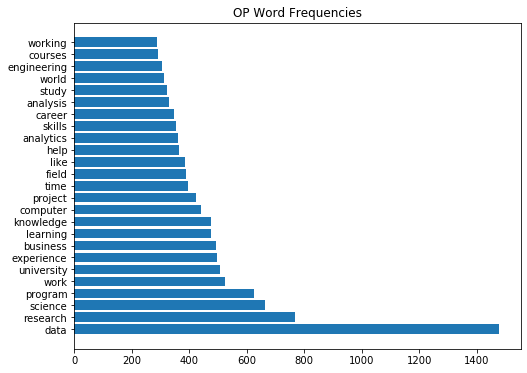

In [19]:
sop_wordcount = Counter(flatten([*df_origpost.tokens.apply(filter_words)]))
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(*list(zip(*sop_wordcount.most_common(25))))
ax.set_title('OP Word Frequencies');

"data" is by far the most common term shared across these documents, unsurprising considering the pre-filtering method used. Perhaps most surprising is the lack of any technologies on the top 25 list. Of course, since these documents are primarily statements of purpose, generally the mention of specific skills is saved for another document.

Regardless, we can still have a look at the frequency of a few common data science related technologies.

In [117]:
for tech in ['python','r','sql','tensorflow','pytorch','c','c++','java','aws','git','hadoop','spark','julia', 'javascript']:
    print('{}: {}'.format(tech,sop_wordcount[tech]))

python: 66
r: 30
sql: 52
tensorflow: 2
pytorch: 2
c: 35
c++: 0
java: 55
aws: 3
git: 2
hadoop: 12
spark: 6
julia: 0
javascript: 13


Python coming in with the most mentions, followed by Java, SQL, and R. These findings are quite similar to those seen from the [Kaggle Survey 2018](kaggle.com/kaggle/kaggle-survey-2018), but it should be noted that "c++" was likely tokenized into "c" and "++".

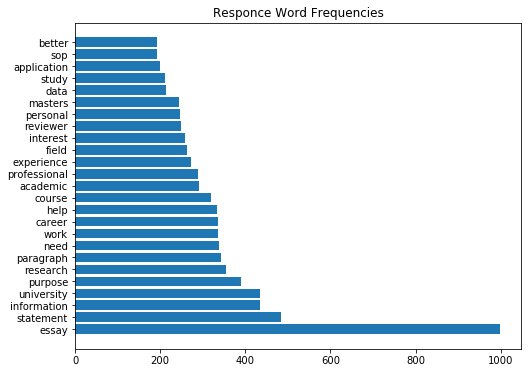

In [20]:
reply_wordcount = Counter(flatten([*df_responce.tokens.apply(filter_words)]))
fig, ax = plt.subplots(figsize=(8,6))
ax.barh(*list(zip(*reply_wordcount.most_common(25))))
ax.set_title('Responce Word Frequencies');

Looking at the replies, "essay" is now most common, along with other textual referencing words. Seeing "help" that high could be an a result of not first filtering out the original poster's replies in the thread. Phrases like "thanks for the help", or "I appreciate the help" may be common in those instances. Perhaps looking at bi-grams/tri-grams could give us most context to work with.

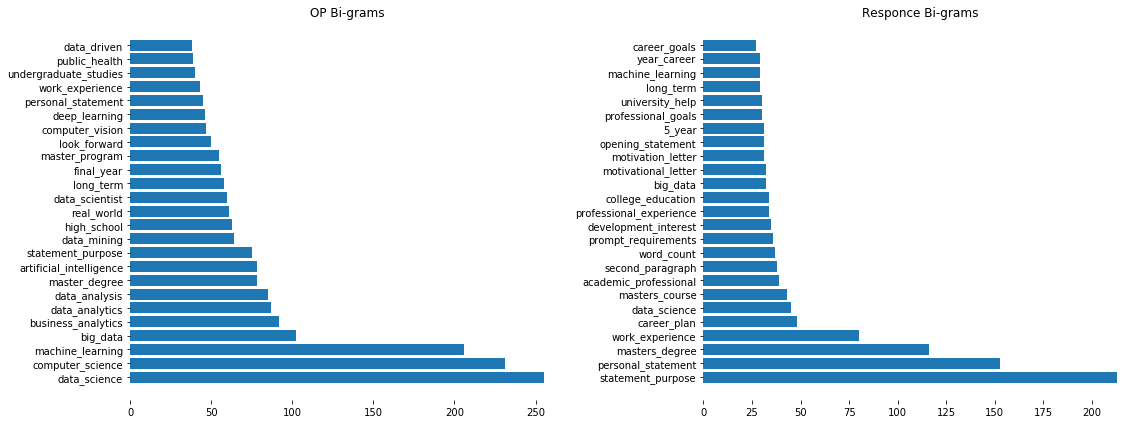

In [21]:
bigram_op = Counter(flatten([*df_origpost.tokens.apply(lambda x: nltk.ngrams(filter_words(x),2))]))
bigram_re = Counter(flatten([*df_responce.tokens.apply(lambda x: nltk.ngrams(filter_words(x),2))]))

fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].barh(*list(zip(*[("_".join(bg),fq) for bg,fq in bigram_op.most_common(25)])))
axes[1].barh(*list(zip(*[("_".join(bg),fq) for bg,fq in bigram_re.most_common(25)])))
axes[0].set_title('OP Bi-grams')
axes[1].set_title('Responce Bi-grams')
axes[0].set_frame_on(False)
axes[1].set_frame_on(False)
plt.tight_layout()
plt.show()

The OP posts have fairly common collocates, at least for the world of data science. A somewhat surprising inclusion on the top 25 list is "high school". Omitting high school achievements is a notion that is largely agreed upon, but again, without context it is difficult determine if any faux pas have occurred.

On the response side, we can start to infer some form of recognizable advice. Noteworthy pairs might include "career plan", "word count", "prompt requirements", "5 year", and "long term". These seem to allude to documents being to short/long, insufficient prompt answers, and professional goals.

In [22]:
cnt_vctzr = CountVectorizer(ngram_range=(1,3),min_df=3)
cnt_vctzr.fit(df_data_A.tokens.apply(lambda x: " ".join(filter_words(x))))
ubtgrams_op = cnt_vctzr.transform(df_origpost.tokens.apply(lambda x: " ".join(filter_words(x))))
ubtgrams_re = cnt_vctzr.transform(df_responce.tokens.apply(lambda x: " ".join(filter_words(x))))

In [23]:
ubtgram_freq_op = pd.Series(ubtgrams_op.sum(axis=0).A1, cnt_vctzr.get_feature_names()).sort_values(ascending=False)
ubtgram_freq_re = pd.Series(ubtgrams_re.sum(axis=0).A1, cnt_vctzr.get_feature_names()).sort_values(ascending=False)

tgrams_op = ubtgram_freq_op[ubtgram_freq_op.index.str.split().str.len() == 3]
tgrams_re = ubtgram_freq_re[ubtgram_freq_re.index.str.split().str.len() == 3]

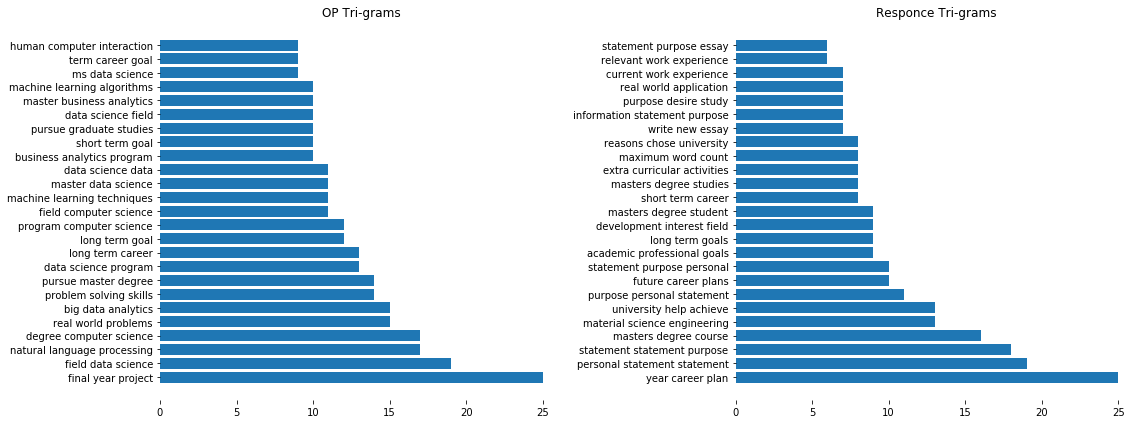

In [24]:
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].barh(tgrams_op[:25].index,tgrams_op[:25])
axes[1].barh(tgrams_re[:25].index,tgrams_re[:25])
axes[0].set_title('OP Tri-grams')
axes[1].set_title('Responce Tri-grams')
axes[0].set_frame_on(False)
axes[1].set_frame_on(False)
plt.tight_layout()
plt.show()

Tri-grams share largely the same theme as bi-grams, although, we now see "reasons [to] choose [the] university" on the responses list. There is also the rather odd "statement statement purpose" and "personal statement statement", likely a side-effect of removing punctuation/stop words.

### Sentiment Analysis (Critiques)

**Note**: After an attempt to manually label a portion of the data, it appears as though this problem is ill-suited for sentiment analysis. Most reviews share a common advice-oriented tone and avoid emotionally charged language. If any sentiment is expressed it is primarily in the form "I like how you X, but you could do Y as well".

Attempts considered:
* TextBlob
* VADER
* Naïve Bayes
* Pre-trained pytorch model

In [216]:
def multi_sentiment(strdoc):
    vader = sia.polarity_scores(strdoc)
    nb = nba.analyze(strdoc)
    tb = TextBlob(strdoc).sentiment
    
    sentims = [tb.polarity, vader['compound'], vader['pos'], nb.p_pos, vader['neg'], nb.p_neg, vader['neu'], tb.subjectivity]
    return np.array(sentims)

In [217]:
critique_sentim = [multi_sentiment(p) for p in df_critiques.post_content]

In [218]:
sentim_df_cols = ['polarity','vader_compd', 'vader_pos', 'nb_pos', 'vader_neg', 'nb_neg', 'vader_neu', 'subjectivity']
df_crit_sentim = pd.concat([df_critiques['doc_id'],pd.DataFrame(critique_sentim,index=df_critiques.index, columns=sentim_df_cols)],1)

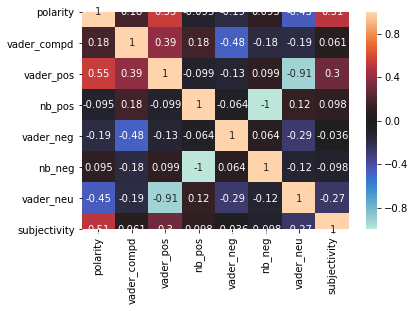

In [219]:
sns.heatmap(df_crit_sentim.corr(), center=0, annot=True);

In [237]:
df_crit_sentim.sort_values(['vader_pos'],ascending=False)[:5]

,doc_id,polarity,vader_compd,vader_pos,nb_pos,vader_neg,nb_neg,vader_neu,subjectivity
177,73506_1,1.000000,0.8316,0.661,0.859435,0.0,0.140565,0.339,1.000000
594,76582_1,-0.016667,0.9455,0.381,0.693815,0.0,0.306185,0.619,0.277778
745,82357_1,0.526667,0.9516,0.375,0.733869,0.0,0.266131,0.625,0.744444
119,68320_1,0.306250,0.9824,0.294,0.994778,0.0,0.005222,0.706,0.636458
475,79140_1,0.380000,0.9442,0.287,0.652359,0.0,0.347641,0.713,0.580000


In [238]:
df_critiques.loc[df_crit_sentim.sort_values(['vader_pos'],ascending=False)[:5].index, 'post_content'].values

array(['@Langk\nIt is awesome and perfect.',
       '@jelif\nI like your essay, but in the third paragraph, I think you should change the first sentence to\n\n... to pursue a masters degree  in computer engineering.\n\nHope I am helpful.\nPlease help with my common app?',
       'Hi! I think this is a good start, however, I feel like you should structure your sentences better and maybe have a look over your word choice. Since it is an opening paragraph, you want to make sure you start off with strong vocab and sentence structure :)',
       'Dear writer, I am really happy to read your essay. It is completely clear. But let me to give you any suggetions.\n\nIn the first paragraph, better if you change word "Hope " to "Hoping or To hope ", and "For me, Earth science and specifically Petroleum Science " change to "For me, Earth Science, especially Petroleum Science "\n\nHoping to achieve immortality with his contribution to society, science and future. For me, Earth science, especially Pe

In [246]:
df_critiques.tokens.loc[177]

@Langk
It is awesome and perfect.

Observations: 

* VADER compound: fairly good at identifying extremes, but cannot differentiate between primarily positive/negative. Subjective tests found that the compound pulled highly critical reviews for both low and high values. Additionally, it favored long reviews over short.

- Polarity: Inconclusive

- NaiveBayes: Inconclusive

- Subjectivity: Surprisingly, one of the few metrics that correlated strongly with a staple highly positive review: 
> 177, 73506_1, "@Langk\nIt is awesome and perfect."

## Models

In [5]:
df_text = pd.read_pickle('data/proc_data/minparse/full_text_minproc.pkl')
op_idx = np.load('data/proc_data/minparse/op_idx.npy')
op_rep_idx = np.load('data/proc_data/minparse/op_rep_idx.npy')
crit_idx = np.load('data/proc_data/minparse/crit_idx.npy')

In [6]:
df_op = df_text.loc[op_idx]
df_crit = df_text.loc[crit_idx]

In [76]:
df_crit

,doc_id,url_id,user_id,seqnum,post_content,tokens
1,82750_1,82750,99412,1,"Yeu, I am afraid that this is not a valid stud...","[xxmaj, yeu, ,, i, am, afraid, that, this, is,..."
4,82755_1,82755,112560,1,"Since this is an academic paper, please remove...","[xxmaj, since, this, is, an, academic, paper, ..."
5,82784_1,82784,112560,1,This comments are just some suggestions that m...,"[xxmaj, this, comments, are, just, some, sugge..."
6,82784_2,82784,112562,2,"Itha20,\n\nLooking through your essay, I think...","[xxmaj, itha20, ,, \n \n , xxmaj, looking, thr..."
7,82784_3,82784,112095,3,I think your essay is a little messy. I would ...,"[i, think, your, essay, is, a, little, messy, ..."
...,...,...,...,...,...,...
11977,16825_2,16825,4916,2,simplify:\n...have had the chance to be Andrei...,"[simplify, :, \n , ..., have, had, the, chance..."
11978,16887_1,16887,21087,1,A Brief Glance...\n\noutspoken extrovert (redu...,"[a, xxmaj, brief, xxmaj, glance, ..., \n \n , ..."
11979,16887_2,16887,4916,2,"...with his mutt, Crakerjack. ---- I added a c...","[..., with, his, mutt, ,, xxmaj, crakerjack, ...."
11983,16827_2,16827,12827,2,"By giving you threads, you mean some threads t...","[xxmaj, by, giving, you, threads, ,, you, mean..."


In [7]:
df_text

,doc_id,url_id,user_id,seqnum,post_content,tokens
0,82750_0,82750,112438,0,"Hi guys, I would need help reviewing this stud...","[xxmaj, hi, guys, ,, i, would, need, help, rev..."
1,82750_1,82750,99412,1,"Yeu, I am afraid that this is not a valid stud...","[xxmaj, yeu, ,, i, am, afraid, that, this, is,..."
2,82755_0,82755,112507,0,Please confine your statement to no more than ...,"[xxmaj, please, confine, your, statement, to, ..."
3,82784_0,82784,112553,0,I really need help in this particular essay. T...,"[i, really, need, help, in, this, particular, ..."
4,82755_1,82755,112560,1,"Since this is an academic paper, please remove...","[xxmaj, since, this, is, an, academic, paper, ..."
...,...,...,...,...,...,...
11980,16896_0,16896,21111,0,"Hello everyone,\nIt would be much appreciated ...","[xxmaj, hello, everyone, ,, \n , xxmaj, it, wo..."
11981,16827_0,16827,20809,0,Some people think that examinations have some ...,"[xxmaj, some, people, think, that, examination..."
11982,16827_1,16827,20809,1,"this topic is about IELTS essay, I need some g...","[this, topic, is, about, xxup, ielts, essay, ,..."
11983,16827_2,16827,12827,2,"By giving you threads, you mean some threads t...","[xxmaj, by, giving, you, threads, ,, you, mean..."


In [4]:
df_text = sop_data[['doc_id','url_id','user_id','seqnum','tokens']].copy()
df_text.head()

,doc_id,url_id,user_id,seqnum,tokens
0,82750_0,82750,112438,0,"[xxmaj, hi, guys, ,, i, would, need, help, rev..."
1,82750_1,82750,99412,1,"[xxmaj, yeu, ,, i, am, afraid, that, this, is,..."
2,82755_0,82755,112507,0,"[ , xxhlb, xxmaj, please, confine, your, state..."
3,82784_0,82784,112553,0,"[i, really, need, help, in, this, particular, ..."
4,82755_1,82755,112560,1,"[xxmaj, since, this, is, an, academic, paper, ..."


In [8]:
detok_rgx = re.compile(r'xx[befghimpqu][a-z]{1,4}|xxred') # match all special tokens except xxdel, xxwrep, xxrep
full_nospec = df_text.tokens.apply(lambda x: [t for t in x if not re.match(detok_rgx,t)])

### Full Data

#### FastText

CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. 

In [71]:
m_fasttext200 = models.FastText(size=200, window=5, sg=1, min_count=5, workers=4)
# paper used size=50,200; window=3-5
m_fasttext200.build_vocab(sentences=full_nospec)
m_fasttext200.train(sentences=full_nospec, total_examples=len(full_nospec), epochs=25)
m_fasttext200.save('saves/models/fasttext_full_sg_200w5e25.gen')
# m_fasttext200 = models.FastText.load('saves/models/fasttext_full_sg_200w5e25.gen')
m_fasttext200.total_train_time

577.9285991999905

In [45]:
ft300 = models.FastText(size=300, window=5, sg=1, min_count=5, negative=10, workers=4)
ft300.build_vocab(sentences=full_nospec)
ft300.train(sentences=full_nospec, total_examples=len(full_nospec), epochs=10)
ft300.save('saves/models/fasttext_full_sg_300w5n10.gen')
ft300.wv.save_word2vec_format('saves/models/fasttext_full_sg_300w5n10.vec')
ft300.total_train_time

419.1474318999981

In [15]:
ft300 = models.FastText.load('saves/models/fasttext_full_sg_300w5n10.gen')

In [14]:
opcrit = df_op.post_content.append(df_crit.post_content)

In [16]:
ft300.train(sentences=opcrit, total_examples=len(opcrit), epochs=15)

In [207]:
simop_0="""\
A visit to a hospital once made me wonder as to why many people often \
fall sick and visit the doctor and run around clinics, while there are \
few who just stay fine and healthy even if they are down with the flu.\
"""
simrv_0="""\
"A visit to a hospital made me wonder why many people tend to become sick \
while having to go to many different clinics seeing many doctors while there \
are others who appear to be healthy only encountering such illnesses as the flu".\
"""
simop_1="""\
There is nothing that comes easy, I ensure to put in my whole effort to do my best and become proficient in the language.\
"""
simrv_1="""\
In that same paragraph change "There is nothing that ... in the language: to \
While most things do not come easy, I desire to put forth the needed effort to become proficient in the language......\
"""
simop_2="""But I believe that ,like marathon, language learning is a process of accumulation."""
simrv_2="""However, I believe that learning a language is like running a marathon: that it is, after all, a process of accumulation."""

difop_0="""I really need help in this particular essay."""
difrv_0="""I think your essay is a little messy."""

In [212]:
# cosine similarity
(ft300.wv.n_similarity(simop_0.split(), simrv_0.split()),
 ft300.wv.n_similarity(difop_0.split(), difrv_0.split()))

(0.95670116, 0.7976724)

In [215]:
# word mover's distance
1-ft300.wv.wmdistance(simop_0,simrv_0), 1-ft300.wv.wmdistance(difop_0,difrv_0)

(0.7837894267415972, 0.6110716830689877)

In [216]:
# Levenshtein edit-distance
nltk.distance.edit_distance(simop_0,simrv_0)

118

#### Doc2Vec

In [10]:
docid2toks = {k:v for k,v in zip(df_text['doc_id'], full_nospec)}
# docid2toks = pickle.load(open('saves/models/fulldict_docid2toks.pkl', 'rb'))
tagged_docs = [models.doc2vec.TaggedDocument(toks,[tid]) for tid,toks in docid2toks.items()]

In [70]:
# paper suggests vector_size 400-600; window 5-12
m_d2v600 = models.Doc2Vec(tagged_docs, epochs=25, vector_size=600, window=8, min_count=5, workers=4)
m_d2v600.save('saves/models/doc2vec_600w8e25.gen')
m_d2v600.total_train_time

153.82064119999268

In [18]:
m_d2v = models.Doc2Vec.load('saves/models/doc2vec_600w8e25.gen')
m_d2v.train(tagged_docs, epochs=75, total_examples=m_d2v.corpus_count)
m_d2v.save('saves/models/doc2vec_600w8e100.gen')

In [8]:
m_d2v = models.Doc2Vec.load('saves/models/doc2vec_600w8e100.gen')

In [39]:
def infer_most_similar(d2v_model, positive=None, negative=None, topn=10, **kwargs):
    """Identify most similar document to OOV documents
    
    kwargs: clip_start=0, clip_end=None, indexer=None,
        infer_vector_kwargs:  alpha=None, alpha_min=None, epochs=None
    """
    infered_pos,infered_neg = None, None
    if positive is not None:
        positive = positive.split() if isinstance(positive,str) else positive
        infered_pos = d2v_model.infer_vector(positive).reshape(1,-1)
    if negative is not None:
        negative = negative.split() if isinstance(negative,str) else negative
        infered_neg = d2v_model.infer_vector(negative).reshape(1,-1)
    return d2v_model.docvecs.most_similar(infered_pos, infered_neg, topn, **kwargs)

In [97]:
def ft_vec2doc(qword='',method='none', ftmodel=m_ft300, d2vmodel=m_d2v):
    """Attempts to find the the most similar document to a given word using using FastText and doc2vec.
    
    Generally speaking, this does not work, nor should it. But nevertheless, 
    it can be intresting to try an idea even if it is doomed fail.
    
    Args:
        qword, str: word to query documents agains
        method, str ('none','repeat', `np.pad method`): method used pad missing dimensionallity
    """
    ftvec = ftmodel.wv.get_vector(qword)
    ft_vs, d2v_vs = ftmodel.vector_size, d2vmodel.vector_size
    if method=='none':
        assert ft_vs == d2v_vs, f"embedding dim mismatch {ft_vs} != {d2v_vs}, use 'repeat' or any valid `np.pad` method"
        ftvec_filled = ftvec
    elif method=='repeat':
        ftvec_filled = ftvec.repeat(d2v_vs//ft_vs)
    else:
        ftvec_filled = np.pad(ftvec, (d2v_vs-ft_vs)//2, method)
    most_sim = d2vmodel.docvecs.most_similar([ftvec_filled])
    print("FT_Sims:", [f'({word}, {sim:0.5f})' for word, sim in ftmodel.wv.most_similar(qword)])
    print("\nd2v_mostsim:", most_sim[0])
    print(" ".join(docid2toks[most_sim[0][0]]))

In [272]:
def doc2ft_vec(docid='', method='none', ftmodel=m_ft300, d2vmodel=m_d2v):
    """Attempts to find the the most similar word to a given document using using FastText and doc2vec."""
    docid = list(docid2toks.keys())[np.random.randint(0, len(docid2toks))] if not docid else docid
    ftmodel.wv.most_similar(d2vmodel.docvecs[docid][300:].reshape(1,-1))
    print(docid)
    print(" ".join(docid2toks[docid]))
    return ftmodel.wv.most_similar(m_d2v.docvecs[docid][300:].reshape(1,-1))

In [12]:
def doc2wv(d2vmodel, docid='random',docid2toks=docid2toks):
    """Find closest word to a given document using the internal word vectors of Doc2Vec"""
    docid = list(docid2toks.keys())[np.random.randint(0, len(docid2toks))] if docid =='random' else docid
    print(docid+':')
    print(" ".join(docid2toks[docid]))
    return d2vmodel.wv.most_similar([d2vmodel.docvecs[docid]])

In [313]:
doc2wv(m_d2v)

26024_0:
i am applying to the graduate program at the university of maryland for education . i am not a strong writer and would love someone to revise my paper and tell me if its okay or not ! thanks y all ! 
 
  a couple of weeks ago i contacted my third grade teacher to personally thank her for her dedication to her profession . everyday in third grade i was eager and excited to go to school because ms. zigethi made learning fun . people ask me everyday what made me interested in teaching , i reply my third grade teacher . i believe children learn best in a welcoming and warm environment , ms. zigethi provided that for each and every student and i hope to do the same . as i started my undergraduate studies i found myself thinking back to third grade . as i entered into my fieldwork and methods courses for elementary education , i felt the passion that those teachers that i volunteered with and worked hand in hand with had , and i could see that the students within those classrooms al

[('crews', 0.21093282103538513),
 ('anxieties', 0.20008012652397156),
 ('sedimentary', 0.19774574041366577),
 ('unsupervised', 0.1924819052219391),
 ('shoots', 0.1900782585144043),
 ('\u200eme', 0.18990479409694672),
 ('.as', 0.18827500939369202),
 ('1985', 0.18798741698265076),
 ('lumbar', 0.18626773357391357),
 ('country].', 0.18500976264476776)]

In [109]:
ft_vec2doc('conciseness', 'empty')

FT_Sims: ['(concise, 0.81788)', '(concisely, 0.73359)', '(vagueness, 0.65922)', '(wordiness, 0.63069)', '(cohesiveness, 0.62532)', '(coherence, 0.62128)', '(succinct, 0.61512)', '(goodness, 0.61088)', '(thoughtfulness, 0.60184)', '(essay, 0.57344)']

d2v_mostsim: ('78635_1', 0.13122059404850006)
mariam , you certainly " threw in the kitchen sink " with this essay . it has way too much information in it that i ca n't figure out what essay you are really trying to write . since this is just a personal statement , there are only 2 things that it has to accomplish . the first , is the idea behind the development of your interest in this course . from there , you need to discuss why you chose this university . now , most people get confused when it comes to writing the personal essay because they often end up writing more information than required . when that happens , no information is left for the sop . so what you have to do with this essay is remove the information that will work better

In [198]:
sad_vec = m_fasttext.wv.get_vector('sad')

In [203]:
m_d2v.docvecs.most_similar([sad_vec.repeat(3)])

[('76085_2', 0.2074853628873825),
 ('40910_0', 0.20669390261173248),
 ('53888_4', 0.2005481868982315),
 ('8791_0', 0.19531497359275818),
 ('6074_1', 0.19520071148872375),
 ('36713_0', 0.19180627167224884),
 ('82755_0', 0.18515659868717194),
 ('53888_7', 0.18473568558692932),
 ('30483_0', 0.1763511598110199),
 ('55940_1', 0.17622730135917664)]

In [209]:
" ".join(docid2toks['76085_2'])

'your response to the top most prompt is incorrect and not applicable . you are being asked to explain why you wish to study in canada , based upon your college major / studies . it is not asking you what government and tourism policies canada has that makes you want to study there . that is irrelevant . the proper answer , requires you to think about the future of mathematics and mathematicians in general and how completing a masters degree in canada will be beneficial to your success in that field . there is nothing in your response that relates to your actual academic interests . a reference must be made to your plans of research , mathematical training , internships , study programs , and other similar interests in your essay . these are the topics of focus for your response . not the useless response that you have written at the moment . \n \n  hafizur , normally , i would be able to advice you on up to 3 of your short posts in a single thread . it is too bad that you posted more 

In [95]:
m_ft300.wv.most_similar(['sad'])

[('disheartened', 0.5977917909622192),
 ('unbearable', 0.5867795944213867),
 ('disheartening', 0.5684282779693604),
 ('sadly', 0.5648922920227051),
 ('angry', 0.5632405281066895),
 ('helpless', 0.5520673990249634),
 ('jealousy', 0.5506688356399536),
 ('unhappy', 0.5468575954437256),
 ('upset', 0.5367089509963989),
 ('miserable', 0.5328792333602905)]

In [67]:
m_ft300.wv.most_similar(['python'],['fun'])

[('stata', 0.4300899803638458),
 ('fortran', 0.4288283586502075),
 ('db2', 0.42803558707237244),
 ('autocad', 0.41547691822052),
 ('vba', 0.4148486256599426),
 ('asp.net', 0.4137452244758606),
 ('uml', 0.40224820375442505),
 ('hdl', 0.3895089030265808),
 ('rdbms', 0.3874324560165405),
 ('xml', 0.38335585594177246)]

In [237]:
m_d2v.wv.most_similar([m_d2v.docvecs[randdoc]])

[('flexibly', 0.26034432649612427),
 ('trillion', 0.24479535222053528),
 ('howard', 0.22973130643367767),
 ('sequestration', 0.22938834130764008),
 ('imre', 0.2260621041059494),
 ('crews', 0.22434477508068085),
 ('richest', 0.2223324477672577),
 ('thomson', 0.22173276543617249),
 ('accra', 0.22106680274009705),
 ('@maria', 0.22061482071876526)]

In [ ]:
def doc_extrema(d2vmodel, tagged_docs=tagged_docs):
    ranks = []
    second_ranks = []
    for tdoc in tagged_docs:
        inferred_vector = d2vmodel.infer_vector(tdoc.words)
        sims = d2vmodel.docvecs.most_similar([inferred_vector], topn=d2vmodel.corpus_count)
        rank = [docid for docid,sim in sims].index(tdoc.tags[0])
        ranks.append(rank)

        second_ranks.append(sims[1])
    return ranks, sims
_, sims = doc_extrema(m_d2v)         

m_d2v.docvecs.most_similar([tagged_docs[0].words], topn=len(m_d2v.docvecs))

doc_id = np.random.randint(0, len(tagged_docs) - 1)

print('Document ({}): «{}»\n'.format(doc_id, ' '.join(tagged_docs[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % m_d2v)

for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(docid2toks[sims[index][0]])))

#### Sent2Vec / SIF Embeddings

Here, we attempt to (re)implement SIF Embbedings from the paper ["A Simple but Tough-to-Beat Baseline for Sentence Embeddings"](https://openreview.net/pdf?id=SyK00v5xx)

The group posted the code for their paper on Github, available here: https://github.com/PrincetonML/SIF

The code below is a slight adaptation of this repository.

In [10]:
import fse

In [ ]:
def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    
    :param We: We[i] is the vector for word i
    :param x: x[i] are the indices of the words in sentence i
    :param w: w[i] are the weights for the words in sentence i
    
    :return: emb[i] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in np.arange(n_samples):
        #emb[i,:] = w[i] @ We[x[i]] / np.count_nonzero(w[i])
        emb[i,:] = vecs[i] * weights[i] / np.count_nonzero(weights[0])
    return emb

def SIF_embedding(We, x, w, npc=1):
    """
    Compute the scores between pairs of sentences using weighted average + removing the projection on the first principal component
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in the i-th sentence
    :param w: w[i, :] are the weights for the words in the i-th sentence
    :param params.rmpc: if >0, remove the projections of the sentence embeddings to their first principal component
    :return: emb, emb[i, :] is the embedding for sentence i
    """
    emb = get_weighted_average(We, x, w)
    if npc > 0:
        emb = remove_pc(emb, npc)
    return emb

counter = CountVectorizer(strip_accents='ascii')
Xc = counter.fit_transform(sents)#.todense().astype("float")

def sent2wordidx(sent):
    return np.array([counter.vocabulary_[w] for w in [x.strip(string.punctuation) for x in sent.lower().split()]])

def sent2wordvecs(sent):
    return np.array([ft300.wv.get_vector(w) for w in [x.strip(string.punctuation) for x in sent.lower().split()]])

ind2weight = {k:v for k,v in zip(np.array([*counter.vocabulary_.values()]),(Xc.sum(axis=0)/Xc.sum()).A1)}
def sent2weights(sent):
    return np.array([ind2weight[counter.vocabulary_[w]] for w in [x.strip(string.punctuation) for x in sent.lower().split()]])

Adapted from: https://www.kaggle.com/procode/sif-embeddings-got-69-accuracy

In [ ]:
def count_words(sents):
    counter = CountVectorizer(strip_accents='ascii')
    Xc = counter.fit_transform(sents).todense().astype("float")
    return Xc
    
def map_word_frequency(document):
    return Counter(itertools.chain(*document))

def sentence2vec(tokenised_sentence_list, embedding_size, word_emb_model, a = 1e-3):
    sentence_vecs = []

    word_counts = map_word_frequency(tokenised_sentence_list)
    sentence_set=[]
    for sentence in tokenised_sentence_list:
        vs = np.zeros(embedding_size)
        sentence_length = len(sentence)
        for word in sentence:
            a_value = a / (a + word_counts[word]) # smooth inverse frequency, SIF

        vs += a_value * word_emb_model[word] # vs += sif * word_vector
        vs /= sentence_length # weighted average
        sentence_set.append(remove_pc(vs))
    return sentence_set

In [ ]:
sentence2vec([sim_ex_crit.split(), dif_ex_crit.split()], 300, ft300.wv)

### Embedding visualization

In [64]:
tsne = TSNE()

In [72]:
doc_tsne = tsne.fit_transform(m_d2v.docvecs.vectors_docs)
tsne_pca = TSNE(init='pca')
doc_tsne_pca = tsne_pca.fit_transform(m_d2v.docvecs.vectors_docs_norm)

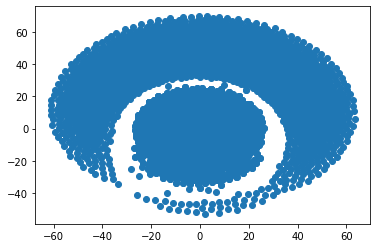

In [80]:
plt.scatter(doc_tsne[:,0],doc_tsne[:,1])

Well, this is an unexpectedly clean separation between groups. Let's try and gain some insight on this

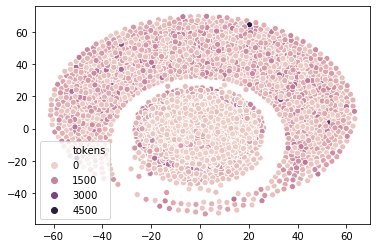

In [92]:
sns.scatterplot(doc_tsne[:,0],doc_tsne[:,1], hue=df_text.tokens.apply(len));

From previous tests, we saw OOV documents tended to be most similar to documents of similar length. This is a reasonable good first place to check, but as we see above, the distinction is not quite so obvious.

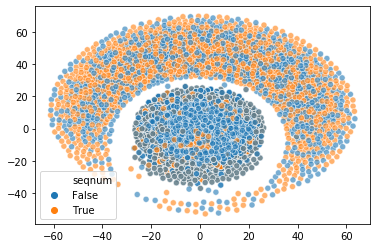

In [134]:
sns.scatterplot(doc_tsne[:,0],doc_tsne[:,1], hue=df_text.seqnum == 0, alpha=0.6);

We see slightly better color separation when encoding with OP/not-OP, but the distinction is still far from clear.

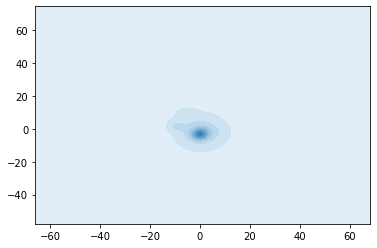

In [148]:
sns.kdeplot(doc_tsne[:,0],doc_tsne[:,1], shade=True);

A density plot reveals that the inner circle contains a disproportionate amount of the documents. The scale is identical for both plots, meaning that the outer ring comprises so few values that it is indistinct from the space containing no samples at all. 

Perhaps we'll see better results with PCA-initialized T-sne.

In [118]:
tsne_pca_df = pd.DataFrame(data=zip(list(m_d2v.docvecs.doctags.keys()), doc_tsne_pca[:,0], doc_tsne_pca[:,1]), columns=['doc_id','x','y'])

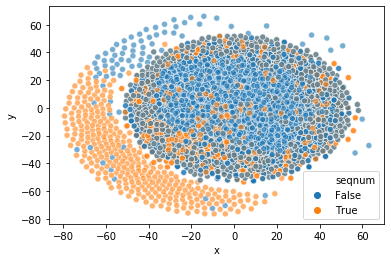

In [122]:
sns.scatterplot(tsne_pca_df['x'],tsne_pca_df['y'], hue=df_text.seqnum == 0, alpha=0.6);

Although PCA initialization did assist in the separation of the outer ring, the density issue has not improved and, in fact, may have actually worsened. T-sne may not be the best fit for our visualization purposes. Calculation time makes tweaking difficult and using a subset may exclude important values given the density disparity.

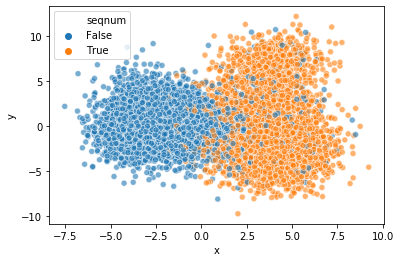

In [115]:
pca = PCA(2)
doc_pca = pca.fit_transform(m_d2v.docvecs.vectors_docs)
pca_df = pd.DataFrame(data=zip(list(m_d2v.docvecs.doctags.keys()), doc_pca[:,0], doc_pca[:,1]), columns=['doc_id','x','y'])
sns.scatterplot(pca_df['x'],pca_df['y'], hue=df_text.seqnum == 0, alpha=0.6);

Using PCA alone we see a cleaner separation between more members of each group, particularly for the OP group.

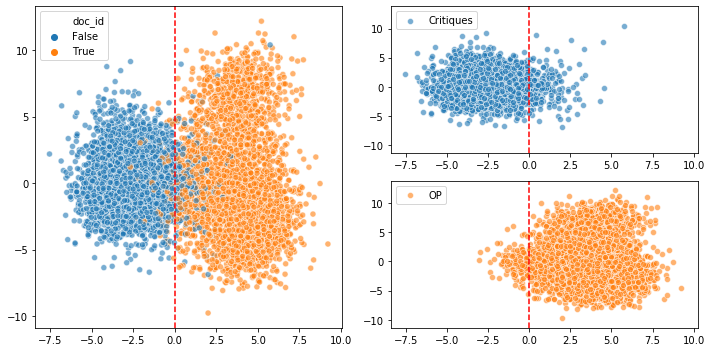

In [194]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(224, sharex=ax2, sharey=ax2)

pca_df = pd.DataFrame(data=zip(list(m_d2v.docvecs.doctags.keys()), doc_pca[:,0], doc_pca[:,1]), columns=['doc_id','x','y'], index=df_text.index) # guarantee shared index
pca_df_opcrit = pca_df.iloc[(df_crit.index) | (df_op.index)] # exclude OP self-responces
pca_df_op = pca_df.iloc[df_op.index]
pca_df_re = pca_df.iloc[df_crit.index]

sns.scatterplot(pca_df_opcrit['x'],pca_df_opcrit['y'], hue=pca_df_opcrit.doc_id.str.endswith('0'), alpha=0.6, ax=ax1);
sns.scatterplot(pca_df_re['x'],pca_df_re['y'], alpha=0.6, color='#1f77b4', ax=ax2, label='Critiques');
sns.scatterplot(pca_df_op['x'],pca_df_op['y'], alpha=0.6, color='#ff7f0f', ax=ax3, label='OP');

for ax in [ax1,ax2,ax3]:
    ax.axvline(color='r',ls='--')
    ax.set_xlabel(None)
    ax.set_ylabel(None)
plt.tight_layout()
plt.show()

Filtering out OP self-responses makes the distinction even more pronounced.

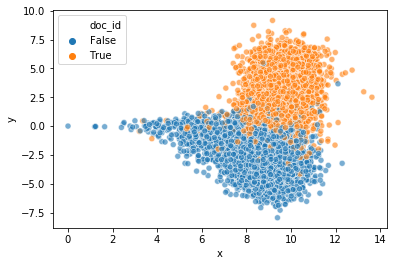

In [214]:
svd = TruncatedSVD(2, n_iter=5)
doc_svd = svd.fit_transform(m_d2v.docvecs.vectors_docs)
svd_df = pd.DataFrame(data=zip(list(m_d2v.docvecs.doctags.keys()), doc_svd[:,0], doc_svd[:,1]), columns=['doc_id','x','y'])
svd_df_opcrit = svd_df.iloc[(df_crit.index) | (df_op.index)]
sns.scatterplot(svd_df['x'],svd_df['y'], hue=svd_df_opcrit.doc_id.str.endswith('0'), alpha=0.6);

SVD also seems to find a distinction between the two groups, but has a larger region of overlapping elements.

### Topic Modeling

In [6]:
def show_topics(a, vocab, n_top_words=8):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

def get_all_topic_words(H, vocab, n_top_words=8):
    top_indices = lambda t: {i for i in np.argsort(t)[:-n_top_words-1:-1]}
    topic_indices = [top_indices(t) for t in H]
    return sorted(set.union(*topic_indices))

In [7]:
def strip_spectoks(toklist,striptoks=['xxmaj','xxup']):
    return [x for x in toklist if x not in striptoks]

In [8]:
def filter_pos(text, keep_pos=['ADJ','NOUN','VERB','ADV']):
    return [t.text for t in filter(lambda t: t.pos_ in keep_pos, nlp(text))] # , disable=['parser','ner']

In [237]:
vctzr_params = dict(stop_words=stopword_common, tokenizer=custom_tokenizer, strip_accents='ascii', ngram_range=(1,3), max_df=0.8, min_df=5)
count_vctzr = CountVectorizer(**vctzr_params)    
tfidf_vctzr = TfidfVectorizer(**vctzr_params)

In [18]:
lda = LatentDirichletAllocation(n_components=10, max_iter=20, learning_method='batch', n_jobs=-1, verbose=1)
nmf = NMF(n_components=10, init=None, max_iter=200, verbose=True)
lsa = TruncatedSVD(n_components=100, n_iter=50)

#### Critiques

In [247]:
fmat = count_vctzr.fit_transform(df_crit.post_content)
ct_ftnames = [*map(lambda x: x.replace(' ','₋'),count_vctzr.get_feature_names())]

In [246]:
pd.Series(fmat.sum(axis=0).A1, index=ct_ftnames).sort_values(ascending=False)

essay                   6649
...                     4633
''                      3518
``                      3316
paragraph               2542
                        ... 
better sentences           5
practice typing            5
explain plans              5
explain professional       5
promotion change           5
Length: 13683, dtype: int64

In [ ]:
tfidf_df = pd.DataFrame(freq_mat.todense(),columns=[i[0] for i in sorted(tfidf_vctzr.vocabulary_.items(), key=lambda x: x[1])]).T
tfidf_df.assign(std_tfidf = tfidf_df.std(axis=1)).sort_values('std_tfidf', ascending=False).head(15)

In [43]:
crit_nospec = df_crit.tokens.apply(strip_spectoks)
# 'essay' is over 2.5x more common than any other word, meaning it will add little value to model topics
crit_pos = crit_nospec.str.join(' ').str.replace('essay','').apply(filter_pos)

In [12]:
count_mat_crit = count_vctzr.fit_transform(crit_pos.str.join(' '))
ct_ftnames = [*map(lambda x: x.replace(' ','₋'),count_vctzr.get_feature_names())]

In [ ]:
tfidf_mat_crit = tfidf_vctzr.fit_transform(crit_pos.str.join(' '))
tf_ftnames = [*map(lambda x: x.replace(' ','₋'),tfidf_vctzr.get_feature_names())]

In [224]:
pd.Series(count_mat_crit.sum(axis=0).A1,ftnames).sort_values(ascending=False)[:10]

essay        6660
paragraph    2546
work         2457
think        2400
sentence     2333
good         2307
make         2210
help         2181
need         2135
statement    2079
dtype: int64

##### LDA

In [78]:
crit_nospec = df_crit.tokens.apply(strip_spectoks,striptoks=({'xxmaj','xxup'})) #stopword_common|{'xxmaj','xxup'}

# 'essay' is over 2.5x more common than any other word, meaning it will add little value to model topics
crit_pos = crit_nospec.str.join(' ').str.replace('essay','').apply(filter_pos)

crit_pos_ns = crit_pos.str.join(' ').apply(gensim.parsing.remove_stopwords).str.split()
crit_dict = corpora.Dictionary(crit_pos_ns)
crit_bow = [crit_dict.doc2bow(c) for c in crit_pos]

In [216]:
# convert to spacy pipeline?
def custom_tokenizer(text):
    """Truncate repeating chars, strip simple punct+whitespace, lowercase"""
    rgx_reps = re.compile(r"(.)\1{2,}")
    #rgx_dash = re.compile(r" ?-{1,}(.+)")
    
    text = rgx_reps.sub(r"\1\1\1", text) # rgx_dash.sub(r" \1", text))
    toks = [t.lower().strip().strip('-') for t in nltk.tokenize.word_tokenize(text)]
    
    return [x for x in filter(lambda t: t not in set(string.punctuation),toks) if x]

# convert to spacy attr?
def digitword(s):
    dwords = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    return s if len(s) > 1 or not s.isdigit() else dwords[int(s)]

In [10]:
df_crit['ctokens'] = df_crit.post_content.apply(custom_tokenizer)

In [229]:
def build_corpus(doc_series, lemmatize=True, pre_strip=None, post_strip=None):
    
    if pre_strip is not None:
        doc_series = doc_series.apply(strip_spectoks,striptoks=pre_strip)
        
    if lemmatize:
        doc_series = doc_series.str.join(' ').apply(lambda x: [digitword(t.lemma_) for t in nlp(x) if not (t.is_punct or t.is_quote)])
    
    common_toks = (stopword_common | set(post_strip) if post_strip is not None else set())
    ngram_min = gensim.models.phrases.Phraser(gensim.models.Phrases(doc_series, min_count = 5, common_terms=common_toks))
    grams = doc_series.apply(lambda x: ngram_min[x])
    
    gram_dict = corpora.Dictionary(grams)
   
    gram_dict.filter_extremes(no_below=5, no_above=0.8)  # filter out overly rare, common, and stopwords
    gram_dict.filter_tokens(bad_ids=[x for x in [gram_dict.token2id.get(t) for t in common_toks] if x])
    
    gram_dict.compactify() # compress mapping to fill gaps left from filtering
    gram_bow = [gram_dict.doc2bow(t) for t in grams]
    
    return grams, gram_dict, gram_bow

In [230]:
post_rm = set(['sentence','paragraph','word','think','write','essay'])
crit_texts, crit_dict, crit_bow = build_corpus(df_crit['ctokens'], lemmatize=True, post_strip=post_rm)

In [220]:
hdp = models.HdpModel(crit_bow,crit_dict)
hdp.get_topics().shape

(150, 5170)

In [221]:
hdp.show_topics(20,num_words=5)

[(0, '0.019*essay + 0.009*work + 0.009*help + 0.008*need + 0.007*use'),
 (1, '0.014*essay + 0.008*work + 0.007*help + 0.006*good + 0.006*need'),
 (2, '0.012*essay + 0.006*work + 0.005*help + 0.005*need + 0.005*like'),
 (3, '0.015*essay + 0.005*like + 0.005*good + 0.004*work + 0.004*need'),
 (4,
  '0.009*essay + 0.005*work + 0.005*need + 0.004*research + 0.004*university'),
 (5, '0.010*essay + 0.004*good + 0.004*need + 0.003*work + 0.003*help'),
 (6, '0.010*essay + 0.003*help + 0.003*good + 0.003*need + 0.003*use'),
 (7, '0.005*essay + 0.002*need + 0.002*help + 0.002*university + 0.002*work'),
 (8,
  '0.004*essay + 0.002*need + 0.002*professional + 0.002*sop + 0.002*information'),
 (9, '0.003*essay + 0.002*use + 0.002*help + 0.002*need + 0.002*research'),
 (10,
  '0.003*essay + 0.002*entrepreneurial + 0.001*study + 0.001*future_career + 0.001*like'),
 (11,
  '0.003*essay + 0.002*need + 0.002*information + 0.002*help + 0.002*program'),
 (12, '0.004*essay + 0.002*study + 0.002*youth + 0.0

In [186]:
lda_gram_args = {'eval_every': 1, 'chunksize': 64, 'passes': 20, 'iterations': 50, 'workers': 3}
lda_gram = models.LdaMulticore(crit_bow, num_topics=6, id2word=crit_dict, per_word_topics=True, **lda_gram_args)
#lda_gram.save('saves/models/lda_crit_t150_p50')

In [246]:
# [x[0] for x in [filter_pos(x, keep_pos=['ADJ','NOUN','VERB','ADV']) for x in list(crit_dict.id2token.values())] if x]

In [253]:
# lda_gram.show_topics(num_words=20, formatted=False)

In [252]:
# lda_gram.top_topics(crit_bow, crit_texts,crit_dict, coherence='c_v')

In [104]:
mlda = models.LdaMulticore(crit_bow, num_topics=150, id2word=crit_dict, workers=3, passes=50)
mlda.save('saves/models/lda_crit_t150_p50')

In [8]:
mlda = models.LdaMulticore.load('saves/models/lda_crit_t150_p50')

In [251]:
# mlda.show_topics(formatted=False)

Alpha (`doc_topic_prior`) controls the similarity of documents. A low value will represent documents as a mixture of few topics, while a high value will output document representations of more topics -- making all the documents appear more similar to each other.

Beta(`topic_word_prior`) is the same but for topics, so it controls topic similarity. A low value will represent topics as more distinct by making fewer, more unique words belong to each topic. A high value will have the opposite effect, resulting in topics containing more words in common.

In [13]:
X_lda = lda.fit_transform(count_mat_crit)

iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 of max_iter: 20
iteration: 15 of max_iter: 20
iteration: 16 of max_iter: 20
iteration: 17 of max_iter: 20
iteration: 18 of max_iter: 20
iteration: 19 of max_iter: 20
iteration: 20 of max_iter: 20


In [14]:
show_topics(lda.components_, ct_ftnames, 10)

['career just paragraph work want good statement need help university',
 'university help paragraph statement think make personal need information study',
 'good work help experience make university think school know need',
 'paragraph good just make sentence think school great experience say',
 'paragraph research work think good sentence make statement want just',
 'work need research help statement purpose good field experience think',
 'paragraph sentence think make help need information statement good use',
 'work university statement need want personal information good help think',
 'sentence good paragraph think make work want school research great',
 'sentence paragraph think statement make work experience reader good help']

In [15]:
[ct_ftnames[i] for i in get_all_topic_words(lda.components_, ct_ftnames, 10)]

['career',
 'experience',
 'field',
 'good',
 'great',
 'help',
 'information',
 'just',
 'know',
 'make',
 'need',
 'paragraph',
 'personal',
 'purpose',
 'reader',
 'research',
 'say',
 'school',
 'sentence',
 'statement',
 'study',
 'think',
 'university',
 'use',
 'want',
 'work']

##### NMF

In [247]:
X_nmf = nmf.fit_transform(tfidf_mat_crit)

In [20]:
show_topics(nmf.components_, tf_ftnames, 10)

['prompt response information question requirements answer prompt₋requirements paragraph questions reviewer',
 'think want really just know writing make write words say',
 'sentence paragraph end idea reader add main end₋paragraph theme think',
 'good luck good₋luck good₋job job great think great₋good good₋like think₋good',
 'masters career professional course degree studies reviewer masters₋degree experience information',
 'statement personal purpose personal₋statement statement₋purpose information university write development writing',
 'goals sop program future achieve future₋goals help help₋achieve program₋help talk',
 'letter motivation motivation₋letter motivational motivational₋letter letter₋motivation information application intent letter₋intent',
 'research engineering university study science field computer petroleum project chemical',
 'school business life people work experience health skills time knowledge']

In [248]:
#[tf_ftnames[i] for i in get_all_topic_words(nmf.components_, tf_ftnames, 15)]

##### LSA / Truncated SVD

In [23]:
X_lsa = lsa.fit_transform(tfidf_mat_crit)

In [250]:
# show_topics(lsa.components_, tf_ftnames, 10)

In [249]:
#[tf_ftnames[i] for i in get_all_topic_words(lsa.components_, tf_ftnames, 15)]

### Kmeans

In [44]:
crit_pos

1        [am, afraid, is, not, valid, study, plan, have...
4        [is, academic, paper, remove, such, statements...
5        [comments, are, just, suggestions, may, help, ...
6        [looking, think, already, better, lot, others,...
7        [think, is, little, messy, would, recommend, a...
                               ...                        
11977    [simplify, have, had, chance, be, subject, pro...
11978    [brief, glance, outspoken, extrovert, redundan...
11979    [mutt, crakerjack, added, comma, capitalize, i...
11983    [giving, threads, mean, threads, start, branch...
11984    [is, really, good, subject, discuss, bad, effe...
Name: tokens, Length: 5534, dtype: object

In [69]:
inf_crit = [m_d2v.infer_vector(c,epochs=100) for c in tqdm_notebook(crit_pos)]

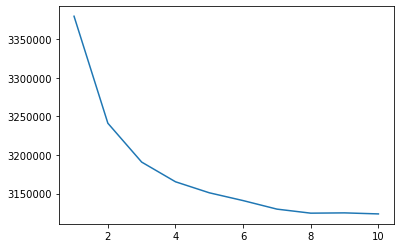

In [70]:
# d2v
plt.plot(*zip(*[(n,KMeans(n).fit(inf_crit).inertia_) for n in range(1,11)]))

In [71]:
kmeans = KMeans(n_clusters=3, n_jobs=-1, verbose=True)

In [72]:
X_km = kmeans.fit_transform(inf_crit)

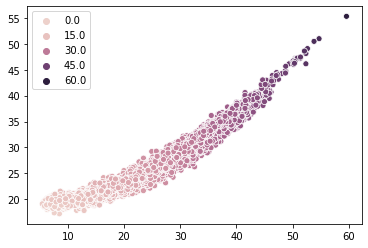

In [79]:
sns.scatterplot(X_km[:, 0], X_km[:,1], hue=X_km[:,2]); # TODO: use vector norm

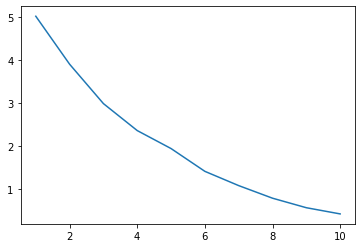

In [341]:
# lda
plt.plot(*zip(*[(n,KMeans(n).fit(X_lda).inertia_) for n in range(1,11)]))

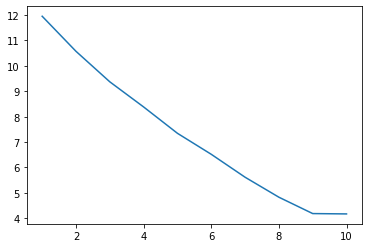

In [338]:
# lsa
plt.plot(*zip(*[(n,KMeans(n).fit(X_lsa).inertia_) for n in range(1,11)]))

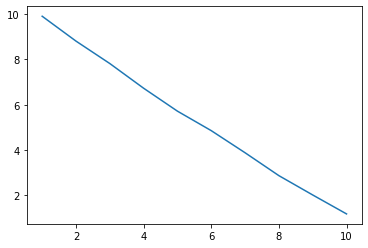

In [340]:
# nmf
plt.plot(*zip(*[(n,KMeans(n).fit(X_nmf).inertia_) for n in range(1,11)]))

In [315]:
mdl_km = KMeans(10)

In [316]:
X_km = mdl_km.fit_transform(X_lsa)

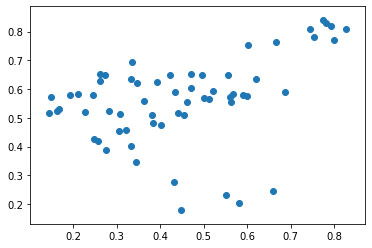

In [317]:
plt.scatter(X_km[:,0],X_km[:,1])

### Coherence

In [223]:
def compute_coherence_values(dictionary, corpus, texts, ntopics, ldam_kwargs=None):
    """Compute c_v coherence for various number of topics

    Parameters
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    ntopics : list(int), topic values to try 
    ldam_kwargs: dict, keyword arguments passed to LdaMulticore

    Returns
    -------
    LdaMulticore model, most coherent model
    coherence_values : Coherence values corresponding to each number of topics tested
    
    Reference
    ---------
    https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
    """
    coherence_list,model_list = [],[]
    for num_topics in tqdm_notebook(ntopics):
        ldamodel = gensim.models.LdaMulticore(corpus, num_topics, id2word=dictionary, **ldam_kwargs)
        model_list.append(ldamodel)
        coherencemodel = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_list.append(coherencemodel.get_coherence())
    print("Best= n_topics: {}, score: {}".format(ntopics[np.argmax(coherence_list)], np.max(coherence_list)))
    return model_list[np.argmax(coherence_list)], coherence_list

In [231]:
topicvals = np.arange(2, 22, 1)
#topicvals = np.linspace(2, 27, num=15, dtype=int)
ldaargs = dict(eval_every=1, chunksize=64, passes=25, iterations=100, workers=3)

In [232]:
top_mod, coherence_values = compute_coherence_values(crit_dict, crit_bow, crit_texts, topicvals, ldam_kwargs=ldaargs)


Best= n_topics: 4, score: 0.3889923477499253


In [235]:
top_mod.show_topics(num_words=20,formatted=False)

[(0,
  [('work', 0.01500688),
   ('research', 0.0121164825),
   ('study', 0.01148163),
   ('field', 0.008526236),
   ('program', 0.008165343),
   ('knowledge', 0.0077499864),
   ('year', 0.007535085),
   ('university', 0.007302193),
   ('interest', 0.006774206),
   ('learn', 0.0059571043),
   ('student', 0.005882607),
   ('project', 0.0058760406),
   ('business', 0.0053775795),
   ('experience', 0.0052978517),
   ('develop', 0.0052134846),
   ('course', 0.005110217),
   ('design', 0.0050288676),
   ('engineering', 0.0047871484),
   ('opportunity', 0.0047545615),
   ('career', 0.0046588825)]),
 (1,
  [('post', 0.018333374),
   ('sop', 0.015984243),
   ('try', 0.015236315),
   ('prompt', 0.01492416),
   ('content', 0.01460705),
   ('paper', 0.012551934),
   ('long', 0.011808809),
   ('information', 0.011047734),
   ('need', 0.010687498),
   ('read', 0.010663434),
   ('review', 0.010297938),
   ('use', 0.009861623),
   ('revise', 0.00952655),
   ('sure', 0.008977778),
   ('edit', 0.008753

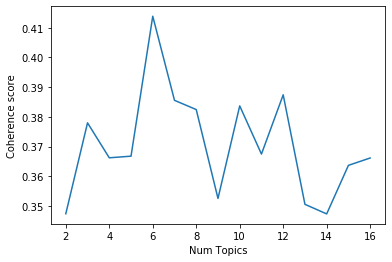

Best= n_topics: 6, score: 0.41385493978660276
LDA args: {'eval_every': 1, 'chunksize': 128, 'passes': 10, 'iterations': 50, 'workers': 3}


In [98]:
fig, ax = plt.subplots()
ax.plot(topicvals, coherence_values)
ax.set_xlabel("Num Topics")
ax.set_ylabel("Coherence score")
plt.show()
print("Best= n_topics: {}, score: {}".format(topicvals[np.argmax(coherence_values)], np.max(coherence_values)))
print("LDA args:",ldaargs)

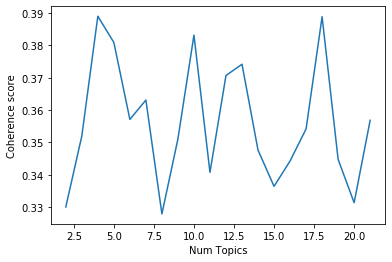

Best= n_topics: 4, score: 0.3889923477499253
LDA args: {'eval_every': 1, 'chunksize': 64, 'passes': 25, 'iterations': 100, 'workers': 3}


In [234]:
fig, ax = plt.subplots()
ax.plot(topicvals, coherence_values)
ax.set_xlabel("Num Topics")
ax.set_ylabel("Coherence score")
plt.show()
print("Best= n_topics: {}, score: {}".format(topicvals[np.argmax(coherence_values)], np.max(coherence_values)))
print("LDA args:",ldaargs)

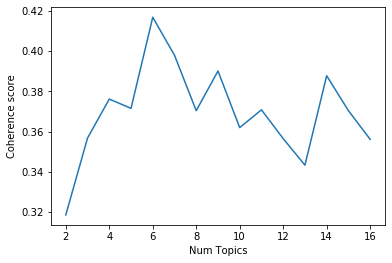

Best= n_topics: 6, score: 0.4168539326797518
LDA args: {'eval_every': 1, 'chunksize': 64, 'passes': 20, 'iterations': 50, 'workers': 3}


In [155]:
fig, ax = plt.subplots()
ax.plot(topicvals, coherence_values)
ax.set_xlabel("Num Topics")
ax.set_ylabel("Coherence score")
plt.show()
print("Best= n_topics: {}, score: {}".format(topicvals[np.argmax(coherence_values)], np.max(coherence_values)))
print("LDA args:",ldaargs)

## Conclusions


**Limitations**
* The data was collected from a single site, this inherently introduces bias into the analysis. There is potential for future improvement by drawing from a diverse pool of reviewed application documents, but there are few as large are as the site used for the analysis.
* There is a core group of contributers on the site whose presence dominates all others. This further compounds the bias problem and strong conflicts with the intended motivations of the analysis.
* The dataset provides no certainty in our findings. Without knowledge of each applicants enrollment outcome, we are left to rely on intuitions about the results of the analysis.

**Future Work**
* After considering the main analysis finished, it was discovered that a paper had been published with similar motivations: ["Is your Statement Purposeless? Predicting Computer Science Graduation Admission Acceptance based on Statement Of Purpose"](https://arxiv.org/pdf/1810.04502.pdf). If the authors are willing to publish the dataset, a semi-supervised approach could be utilized to better the results of the analysis.



### References

https://radimrehurek.com/gensim/models/doc2vec.html

https://radimrehurek.com/gensim/models/fasttext.html

https://medium.com/@pmin91/aspect-based-opinion-mining-nlp-with-python-a53eb4752800

https://github.com/pmin91/DS_projects/blob/master/04-Aspect_Based_Opinion_Mining/code/02-Sentiment_Analysis.ipynb

https://github.com/huggingface/neuralcoref

https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e

https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28

https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-6-doc2vec-603f11832504

https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-7-phrase-modeling-doc2vec-592a8a996867

https://stackoverflow.com/questions/17421887/how-to-determine-the-number-of-topics-for-lda

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#17howtofindtheoptimalnumberoftopicsforlda

https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/